# PPO - Proximal Policy Optimization


At the end of the _policy gradient_ notebook, we identified the techniques used in PPO. The
[PPO algorithm](https://arxiv.org/abs/1707.06347) was inspired by trying to simplify _TRPO_, for
more details please check
[this video](https://www.youtube.com/watch?v=KjWF8VIMGiY&list=PLwRJQ4m4UJjNymuBM9RdmB3Z9N5-0IlY0&index=4).

Here are the techniques we are going to implement:

1.  Learn from multiple parallel / vectorized environments.
2.  Use _Generalized Advantage Estimation_, or [GAE](https://arxiv.org/abs/1506.02438).
3.  Reuse recent experiences to learn in mini-batches (even if technically off-policy).
4.  Clip the policy loss and gradients to prevent the policy from derailing.
5.  Use _trajectory segments_ (instead of entire episodes) for learning.

With all of that, we'll be able to land on the Moon with PPO!


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from dataclasses import dataclass
from torch.distributions.normal import Normal

import gymnasium as gym

from util.gymnastics import gym_simulation, init_random

## Environment


In [ ]:
lunar_lander_kwargs = {
    "continuous": True,
    "gravity": -10.0,
    "enable_wind": False,
    "wind_power": 15.0,
    "turbulence_power": 1.5,
}

/home/alessio/miniconda3/envs/drlzh/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /tmp folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building file /tmp/rl-video.gif with imageio.


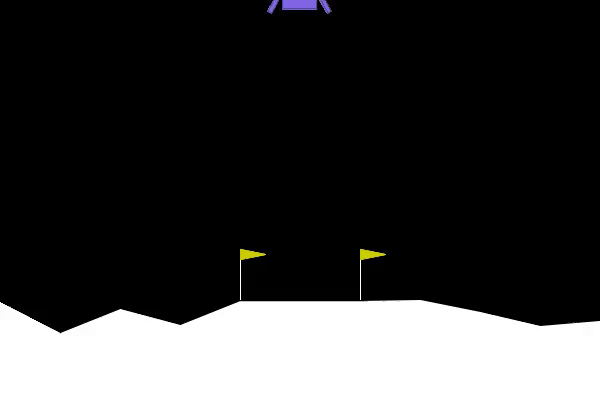

In [3]:
gym_simulation("LunarLander-v3", env_kwargs=lunar_lander_kwargs)

## Trajectory Segments

In PPO learning we don't loop over episodes (and max-steps-per episode). Instead, we learn across
_trajectory segments_, which are stitched together when an episode ends and the next one begins.
That has various advantages, one of which is the ability to better solve long-lasting environments.

For a more in-depth explanation, check out the
[CleanRL PPO implementation explanation](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/),
specifically point 1. This implementation has been inspired in many parts by the CleanRL one.


In [4]:
@dataclass
class TrajectorySegment:
    states: torch.Tensor  # (M, N, S_dim)
    actions: torch.Tensor  # (M, N, A_dim)
    logprobs: torch.Tensor  # (M, N)
    values: torch.Tensor  # (M, N)
    rewards: torch.Tensor  # (M, N)
    dones: torch.Tensor  # (M, N)

    next_start_state: torch.Tensor  # (N, S_dim)

    def __len__(self):
        return self.states.shape[0]

## Mini-batch Learning

Remember that in REINFORCE we threw away the data collected by the agent every time? That is because
once we learn from the experiences, the policy has changed and we cannot reuse the data sampled by
an old policy to learn... but that sounds quite wasteful...

In PPO, for each trajectory segment we can perform multiple epochs of learning in mini-batches
instead! How is that possible?!

It turns out that, if the old and new policy are "similar enough", we can do gradient ascent using
the gradient of the _ratio_ of the new policy over the old policy times the return (a.k.a., the
_surrogate_ function):

$$
g = \nabla_{\theta'} \sum_{t} \frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)} R^{future}
$$

The only difference in the implementation is that we will use
[log probabilities](https://en.wikipedia.org/wiki/Log_probability) for speed and numerical
stability. For an in-depth explanation, see the appendix.

Now that we know that, let's focus on implementing some convenient batching utilities!


In [5]:
@dataclass
class LearningBatch:
    states: torch.Tensor  # (B, S_dim)
    actions: torch.Tensor  # (B, A_dim)
    logprobs: torch.Tensor  # (B)
    advantages: torch.Tensor  # (B)
    returns: torch.Tensor  # (B)

    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, key):
        return LearningBatch(
            self.states[key],
            self.actions[key],
            self.logprobs[key],
            self.advantages[key],
            self.returns[key],
        )

In [6]:
class Batcher:
    def __init__(
        self,
        seg: TrajectorySegment,
        advantages: torch.Tensor,
        returns: torch.Tensor,
        n_mini_batches: int,
    ):
        self.batch_size = seg.states.shape[0] * seg.states.shape[1]  # rollout_len * num_bots
        self.mini_batch_size = int(self.batch_size // n_mini_batches)
        self.experiences = LearningBatch(
            *Batcher.flatten((seg.states, seg.actions, seg.logprobs, advantages, returns))
        )

    def shuffle(self):
        indices = np.arange(self.batch_size)
        np.random.shuffle(indices)
        return Batcher.MiniBatchIterator(self.experiences, indices, self.mini_batch_size)

    @staticmethod
    def flatten(t: tuple[torch.Tensor, ...]) -> tuple:
        return tuple(x.flatten(0, 1) for x in t)

    class MiniBatchIterator:
        def __init__(self, experiences: LearningBatch, indices: list[int], mini_batch_size: int):
            self.experiences = experiences
            self.indices = indices
            self.mini_batch_size = mini_batch_size
            self.start = 0

        def __iter__(self):
            return self

        def __next__(self):
            if self.start >= len(self.experiences):
                raise StopIteration()
            start = self.start
            end = start + self.mini_batch_size
            inds = self.indices[start:end]
            self.start = end
            return self.experiences[inds]

## PPO Agent

Let's implement the PPO agent! In particular, we will implement the loss function as described in
the paper:

$$
L_t^{CLIP + VF + S}(\theta) = \hat{\mathbb{E}_t}[L_t^{CLIP}(\theta) + c_1 L_t^{VF}(\theta) + c_2 S[\pi_\theta](s_t)]
$$

Which is a combined: policy loss (actor) + value loss (critic) + entropy loss. It is important to
optimize a single loss function when the network share layers and weights of the networks (but we
won't do it here).

### Clipping

As mentioned above, we want the policies to remain "similar". To do that, we clip the _ratio_ in the
interval $[1 - \epsilon, 1 + \epsilon]$, as well as the total gradient of the loss. Check out more
details about clipping in the paper itself!


In [7]:
class Agent(nn.Module):
    def __init__(self, state_size, action_size, lr=2.5e-4, weight_mul=1e-3):
        super().__init__()

        def layer_init(layer, std=np.sqrt(2)):
            torch.nn.init.orthogonal_(layer.weight, std)
            torch.nn.init.constant_(layer.bias, 0.0)
            layer.weight.data.mul_(weight_mul)
            return layer

        self.critic = nn.Sequential(
            layer_init(nn.Linear(state_size, 32)),
            nn.Tanh(),
            layer_init(nn.Linear(32, 32)),
            nn.Tanh(),
            layer_init(nn.Linear(32, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(state_size, 32)),
            nn.Tanh(),
            layer_init(nn.Linear(32, 32)),
            nn.Tanh(),
            layer_init(nn.Linear(32, action_size), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, action_size))
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    @torch.no_grad()
    def act(self, state: np.array):
        action, _ = self.sample_action(torch.from_numpy(state).unsqueeze(0))
        return action.numpy()[0]

    def get_value(self, states):
        return self.critic(states)

    def get_action_probs(self, states) -> torch.distributions.Distribution:
        action_mean = self.actor_mean(states)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        return Normal(action_mean, action_std)

    def sample_action(self, states):
        probs = self.get_action_probs(states)
        action = probs.sample()
        return action, probs.log_prob(action).sum(1)

    def eval_action(self, states, action):
        probs = self.get_action_probs(states)
        return probs.log_prob(action).sum(1), probs.entropy().sum(1)

    def learn(
        self,
        batch: LearningBatch,
        entropy_coeff=0.01,
        vf_coeff=0.5,
        clip_coeff=0.1,
        max_grad_norm=0.75,
    ):
        newlogprobs, entropy = self.eval_action(batch.states, batch.actions)

        logratio = newlogprobs - batch.logprobs
        ratio = logratio.exp()
        clipped_ratio = torch.clamp(ratio, 1 - clip_coeff, 1 + clip_coeff)
        advantages = batch.advantages

        L_entropy = entropy_coeff * entropy.mean()
        L_clipped = -torch.min(advantages * ratio, advantages * clipped_ratio).mean()
        L_actor = L_clipped - L_entropy

        newvalues = self.get_value(batch.states).view(-1)
        L_critic = F.mse_loss(newvalues, batch.returns)

        L_ppo = L_actor + L_critic * vf_coeff
        self.optimizer.zero_grad()
        L_ppo.backward()
        nn.utils.clip_grad_norm_(self.actor_mean.parameters(), max_grad_norm)
        nn.utils.clip_grad_norm_(self.critic.parameters(), max_grad_norm)
        self.optimizer.step()

## Advantages and Returns

Recall that intuitively the _advantage_ tells us how much better we are doing taking action $a$ in
state $s$ compared to the "value" of that state (which itself represents the expected return):

$$
A(s_t, a_t) = G_t - V(s_t)
$$

That is the usual / "basic" way of computing advantages: it uses the entire trajectory to compute
the return (in a Monte Carlo fashion). To reduce _variance_, we might want to use bootstrapping and
a current estimate instead. GAE allows to do that, tuning via an extra parameter $\lambda^{GAE}$.

The code for advantages and returns computation is provided. You can easily map the
`basic_advantages_and_returns` method to the formula above, and use the GAE paper to instead dig
deeper into `gae_advantages_and_returns` :)


In [ ]:
@torch.no_grad()
def basic_advantages_and_returns(segment: TrajectorySegment, next_return: torch.Tensor, gamma=0.99):
    returns = torch.zeros_like(segment.rewards).detach()
    running_return = next_return
    for t in reversed(range(len(segment))):
        next_non_terminal = 1.0 - segment.dones[t]
        running_return = segment.rewards[t] + gamma * running_return * next_non_terminal
        returns[t] = running_return
    advantages = returns - segment.values
    return advantages, returns

In [ ]:
@torch.no_grad()
def gae_advantages_and_returns(
    segment: TrajectorySegment, next_return: torch.Tensor, gamma=0.999, gae_lambda=0.98
):
    advantages = torch.zeros_like(segment.rewards)
    last_gae_lambda = 0
    for t in reversed(range(len(segment))):
        next_non_terminal = 1.0 - segment.dones[t]
        td_error = (
            segment.rewards[t] + (gamma * next_return * next_non_terminal) - segment.values[t]
        )
        advantages[t] = td_error + gamma * gae_lambda * next_non_terminal * last_gae_lambda
        next_return = segment.values[t]
        # Reset the last_gae_lambda if an episode terminates half-way (per bot).
        last_gae_lambda = advantages[t] * next_non_terminal

    returns = advantages + segment.values
    return advantages, returns

## PPO Training Loop

No surprises here! The loop is basically:

- Collect a trajectory segment.
- Compute advantages and returns.
- Learn in mini-batches for $n$ epochs.
- Repeat until the environment solved (or max steps).


In [ ]:
class PPO:
    """PPO implementation."""

    def __init__(
        self,
        env: gym.vector.VectorEnv,
        agent: Agent,
        rollout_size=1_024,
        mini_batch_size=64,
        n_update_epochs=4,
        gae_enabled=True,
        solved_score=200.0,
    ):
        self.env = env
        self.agent = agent
        self.num_bots = env.num_envs
        self.n_mini_batches = (rollout_size * self.num_bots) // mini_batch_size
        self.n_update_epochs = n_update_epochs
        self.gae_enabled = gae_enabled
        self.action_size = env.action_space.shape[1]
        self.state_size = env.observation_space.shape[1]
        self.rollout_size = rollout_size
        self.solved_score = solved_score
        self.n_episode = 0

    def train(self) -> list[float]:
        start_state, _ = self.env.reset()
        start_state = torch.Tensor(start_state)

        while True:
            segment = self.collect_trajectory_segment(start_state)

            next_return = self.agent.get_value(segment.next_start_state).flatten()
            advantages, returns = (
                gae_advantages_and_returns(segment, next_return)
                if self.gae_enabled
                else basic_advantages_and_returns(segment, next_return)
            )

            batcher = Batcher(segment, advantages, returns, self.n_mini_batches)
            for _ in range(self.n_update_epochs):
                for mini_batch in batcher.shuffle():
                    self.agent.learn(mini_batch)

            start_state = segment.next_start_state
            if self.training_checkpoint(segment):
                break

    def collect_trajectory_segment(self, start_state):
        batch_dim = (self.rollout_size, self.num_bots)

        s_states = torch.zeros(batch_dim + (self.state_size,))
        s_actions = torch.zeros(batch_dim + (self.action_size,))
        s_logprobs = torch.zeros(batch_dim)
        s_values = torch.zeros(batch_dim)
        s_rewards = torch.zeros(batch_dim)
        s_dones = torch.zeros(batch_dim)

        state = start_state
        for step in range(self.rollout_size):
            with torch.no_grad():
                action, logprob = self.agent.sample_action(state)
                clipped_action = torch.clamp(action, -1, 1)
                value = self.agent.get_value(state)

            next_state, reward, term, trunc, _ = self.env.step(clipped_action.cpu().numpy())

            s_states[step] = state
            s_actions[step] = action
            s_logprobs[step] = logprob
            s_values[step] = value.flatten()
            s_rewards[step] = torch.Tensor(reward)
            s_dones[step] = torch.Tensor(np.logical_or(term, trunc))

            state = torch.Tensor(next_state)

        return TrajectorySegment(
            s_states, s_actions, s_logprobs, s_values, s_rewards, s_dones, next_start_state=state
        )

    @torch.no_grad()
    def training_checkpoint(self, segment: TrajectorySegment) -> bool:
        """Print statistics and determines whether to terminate training."""
        for t in range(len(segment)):
            for b in range(self.num_bots):
                is_episode_end = segment.dones[t, b] == True
                if is_episode_end:
                    self.n_episode += 1
                    avg_score = np.mean(self.env.return_queue)
                    print(
                        f"\rEpisode {self.n_episode}\tAverage Score: {avg_score:.2f}",
                        end="\n" if self.n_episode % 250 == 0 else "",
                    )
                    if avg_score > self.solved_score:
                        print(
                            f"\rEpisode {self.n_episode} solved environment! "
                            + f"Average Score: {avg_score:.2f}"
                        )
                        return True
        return False

In [11]:
vector_env = gym.make_vec("LunarLander-v3", num_envs=10, **lunar_lander_kwargs)
vector_env = gym.wrappers.vector.RecordEpisodeStatistics(vector_env)
vector_env = init_random(vector_env)
agent = Agent(vector_env.observation_space.shape[1], vector_env.action_space.shape[1])
ppo = PPO(vector_env, agent)
ppo.train()

Episode 250	Average Score: -229.75
Episode 500	Average Score: -163.64
Episode 750	Average Score: -132.41
Episode 1000	Average Score: -93.66
Episode 1250	Average Score: -79.64
Episode 1500	Average Score: -60.40
Episode 1750	Average Score: -50.07
Episode 2000	Average Score: -43.08
Episode 2250	Average Score: -22.83
Episode 2500	Average Score: -10.37
Episode 2750	Average Score: 55.477
Episode 3000	Average Score: 117.51
Episode 3250	Average Score: 131.00
Episode 3500	Average Score: 124.58
Episode 3750	Average Score: 152.62
Episode 4000	Average Score: 147.34
Episode 4250	Average Score: 162.40
Episode 4500	Average Score: 194.95
Episode 4533 solved environment! Average Score: 203.60


/home/alessio/miniconda3/envs/drlzh/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /tmp folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building file /tmp/rl-video.gif with imageio.


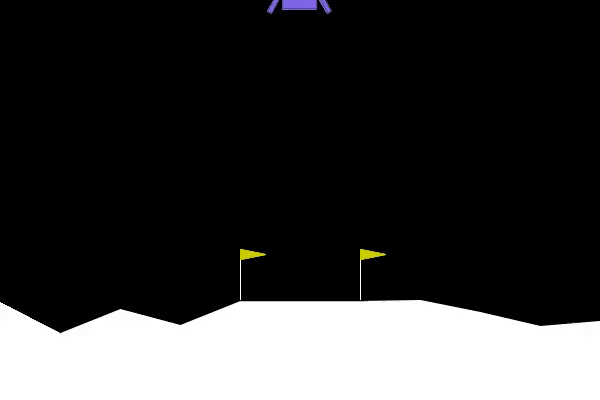

In [12]:
gym_simulation("LunarLander-v3", agent, env_kwargs=lunar_lander_kwargs)

## Appendix

### Off-Policy Policy Gradient (Intuition)

Recall that the objective of reinforcement learning is to maximize the _expected_ return. Hence, we
work with expectations.

If we want to find out the expected value for a function evaluated on multiple trajectories (e.g.,
the return of a reinforcement learning environment), we just go over all trajectories and multiply
by the probability of that trajectory:

$$
\mathbb{E}[R] = \sum_\tau P(\tau)r(\tau)
$$

Where $r$ gives you the return for the trajectory $\tau$ and $P$ its probability. Let say that the
problem is _parameterized_ by the parameters $\theta$, the equation becomes:

$$
\mathbb{E}[R_\theta] = \sum_\tau P_{\theta}(\tau)r(\tau)
$$

This becomes interesting if we consider new parameters $\theta'$. Let's assume the sampling of
$r(\tau)$ happened under old parameters $\theta$, but we now have updated the parameters to
$\theta'$. We cannot compute the _expected value_ just using the old $r$ with the new $P$, but what
we can do is use a trick:

$$
\mathbb{E}[R_{\theta'}] = \sum_\tau P_{\theta}(\tau) \frac{P_{\theta'}(\tau)}{P_{\theta}(\tau)} r(\tau)
$$

The $\frac{P_{\theta'}(\tau)}{P_{\theta}(\tau)}$ is called the _reweighting factor_, and we can
compute updated _expectations_ using old sampled data (technique called _importance sampling_).

---

Let's go back to the policy gradient update, the gradient $g$ is:

$$
g = \sum_t \nabla_{\theta} log\pi_{\theta}(a_t | s_t) R_t^{future}
$$

Mathematically, the gradient of $log$ is equivalent to:

$$
g = \sum_t \frac{\nabla_{\theta} \pi_{\theta}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)} R_t^{future}
$$

Now let's assume we have trajectories (hence, $R_t$) collected under an old policy $\pi_{\theta'}$.
How do we compute the gradient? We can use the reweighting factor:

$$
g = \frac{P_{\theta}(\tau)}{P_{\theta'}(\tau)} \sum_t \frac{\nabla_{\theta} \pi_{\theta}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)} R_t^{future}
$$

$P$ represents the probability of a trajectory under a certain parameter $\theta$:

$$
P_{\theta}(\tau) = p(s_1) \prod_{t=1}^T \pi_{\theta}(a_t|s_t)p(s_{t+1}|s_t,a_t)
$$

Given that the dynamic of the MDP system (i.e., probabilities $p$) are the same, we get:

$$
\frac{P_{\theta}(\tau)}{P_{\theta'}(\tau)} = \prod_{t=1}^T \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta'}(a_t|s_t)}
$$

Let's integrate this term into the gradient considering causality (we discard the future term to be
integrated with the reward term b/c it turns out we obtain still a good approximation):

$$
g = \sum_t  \frac{\nabla_{\theta} \pi_{\theta}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)}
    \prod_{t'=1}^t \frac{\pi_{\theta}(a_{t'}|s_{t'})}{\pi_{\theta'}(a_{t'}|s_{t'})}
    R_t^{future}
$$

That doesn't help much per-se. But if we think about what that fraction represents, we can replace
it with the _marginal_ probabilities of the overall dynamics under the parameterized policies:

$$
g = \sum_t  \frac{\nabla_{\theta} \pi_{\theta}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)}
    \frac{\pi_{\theta}^{mrg}(s_t, a_t)}{\pi_{\theta'}^{mrg}(s_t, a_t)}
    R_t^{future}
$$

This still is not useful by itself: to compute the _marginals_ we would need access to the entire
dynamic of the system. But we can rewrite that in this form (by chain rule):

$$
g = \sum_t  \frac{\nabla_{\theta} \pi_{\theta}(a_t | s_t)}{\cancel{\pi_{\theta}(a_t | s_t)}}
    \frac{\pi_{\theta}^{mrg}(s_t)}{\pi_{\theta'}^{mrg}(s_t)}
    \frac{\cancel{\pi_{\theta}(a_t|s_t)}}{\pi_{\theta'}(a_t|s_t)}
    R_t^{future}
$$

Suddenly, if we could just ignore the _state marginals_ we would get a manageble update for
off-policy / importance-sampling policy gradient.
[It turns out](https://www.youtube.com/watch?v=LtAt5M_a0dI&list=PL_iWQOsE6TfX7MaC6C3HcdOf1g337dlC9&index=40)
that, if the policies are "close" enough (this is where "proximity" plays a critical role), we can
indeed ignore those marginals (in the sense that we get a bounded error). Which gives us the final
update:

$$
g = \nabla_{\theta} \sum_t \frac{\pi_{\theta}(a_t | s_t)}{\pi_{\theta'}(a_t | s_t)} R_t^{future}
$$

For a formal explanation, see
[CS 285: Lecture 5](https://www.youtube.com/watch?v=KZd508qGFt0&list=PL_iWQOsE6TfX7MaC6C3HcdOf1g337dlC9&index=20).
